In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import sys
from google.colab import drive
from torch.autograd import Variable
import matplotlib.pyplot as plt
import argparse

!nvidia-smi
!pip install torchvision==0.5.0
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
drive.mount('/content/gdrive')

Mon Nov 23 14:20:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !unzip 'gdrive/My Drive/colab/hw3/hw3_data.zip' -d 'gdrive/My Drive/colab/hw3/'
# !unzip 'gdrive/My Drive/colab/hw3/hw3_data.zip'

# **Dataset**


```
圖片數量：40000
原始圖片大小：3*64*64
輸出圖片大小：3*4096
```




In [3]:
class Allen(Dataset): 
    def __init__(self, mode, transform = None):
        self.mode = mode
        self.transform = transform
        if self.mode == 'train':
          self.common_path = 'hw3_data/face/train/'
        else:
          self.common_path = 'hw3_data/face/test/'
        self.filename = sorted(os.listdir(self.common_path))
        self.len = len(self.filename)

    def __getitem__(self, index):
        path = os.path.join(self.common_path + str(self.filename[index]))
        im = Image.open(path)
        if self.transform is not None:
            im = self.transform(im)
        
        return im

    def __len__(self):

        return(self.len)

trainset = Allen('train', transform = transforms.ToTensor())
testset = Allen('test', transform = transforms.ToTensor())

train_loader = DataLoader(trainset, batch_size = 8, shuffle = True, drop_last = True)
test_loader = DataLoader(testset, batch_size = 1, drop_last = True)
print('訓練資料大小 : ',len(trainset))
print('測試資料大小 : ',len(testset))
print(trainset.__getitem__(2))

訓練資料大小 :  40000
測試資料大小 :  2621
tensor([[[0.3843, 0.3569, 0.3686,  ..., 0.1255, 0.1333, 0.1333],
         [0.3922, 0.3765, 0.3647,  ..., 0.1176, 0.1216, 0.1294],
         [0.3961, 0.3725, 0.3451,  ..., 0.1216, 0.1255, 0.1255],
         ...,
         [0.8314, 0.8353, 0.8275,  ..., 0.0941, 0.1020, 0.1020],
         [0.8314, 0.8471, 0.8353,  ..., 0.0941, 0.1020, 0.1059],
         [0.8118, 0.8314, 0.8235,  ..., 0.0941, 0.1059, 0.1020]],

        [[0.2471, 0.2235, 0.2431,  ..., 0.0863, 0.0863, 0.0902],
         [0.2510, 0.2431, 0.2392,  ..., 0.0824, 0.0863, 0.0980],
         [0.2510, 0.2431, 0.2196,  ..., 0.0863, 0.0902, 0.0902],
         ...,
         [0.6510, 0.6627, 0.6627,  ..., 0.0588, 0.0667, 0.0667],
         [0.6510, 0.6667, 0.6706,  ..., 0.0588, 0.0667, 0.0706],
         [0.6314, 0.6549, 0.6549,  ..., 0.0627, 0.0706, 0.0667]],

        [[0.2706, 0.2510, 0.2745,  ..., 0.1608, 0.1569, 0.1569],
         [0.2706, 0.2706, 0.2706,  ..., 0.1569, 0.1608, 0.1686],
         [0.2745, 0.2745, 0

In [4]:
class VAE(nn.Module):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims = None) -> None:
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z):
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return  self.decode(z), mu, log_var

In [5]:
model = VAE(in_channels = 3, latent_dim = 1024).to(device)
loss_function = nn.MSELoss()
print(model)
#0.0005
#0.00005

VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequentia

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.00001,betas=(0.5, 0.999))
def train(epoch,MSE_list,KL_list):
    model.train()
    train_loss = 0
    for batch_idx, x in enumerate(train_loader):
        x = x.to(device)
        x_reconst, mu, log_var = model(x)
        
        MSE_loss = 0
        KL_loss = 0
        reconst_loss = loss_function(x_reconst, x)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # print('MSE loss : ',reconst_loss)
        # print('KL : ',kl_div)

        loss = reconst_loss + 0.00001 * kl_div
        # loss = reconst_loss 
        train_loss += loss.item()
        MSE_loss += reconst_loss.item()
        KL_loss += kl_div.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        MSE_list.append(reconst_loss.item())
        KL_list.append(kl_div.item())
        # if batch_idx % 400 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(x), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader),
        #         loss.item() / 1))
        #     print('MSE : ',MSE_loss)
        #     print('KL : ',KL_loss)
            

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader)))
    return MSE_list, KL_list

In [7]:
# Plot
def plotMSEImage(G_losses):
    print('Start to plot!!')
    plt.title("MSE_loss")
    plt.plot(G_losses, label="MSE")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
def plotKLImage(G_losses):
    print('Start to plot!!')
    plt.title("KL_loss")
    plt.plot(G_losses, label="KL")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [21]:
# MSE_list = []
# KL_list = []
for i in range(10):
  MSE_list, KL_list = train(i,MSE_list,KL_list)
# plotMSEImage(MSE_list)

# plotKLImage(KL_list)

====> Epoch: 0 Average loss: 0.0136
====> Epoch: 1 Average loss: 0.0136
====> Epoch: 2 Average loss: 0.0136
====> Epoch: 3 Average loss: 0.0136
====> Epoch: 4 Average loss: 0.0135
====> Epoch: 5 Average loss: 0.0135
====> Epoch: 6 Average loss: 0.0135
====> Epoch: 7 Average loss: 0.0135
====> Epoch: 8 Average loss: 0.0134
====> Epoch: 9 Average loss: 0.0134


In [9]:
# model = torch.load('gdrive/My Drive/colab/hw3/1117')

**顯示目前model重新建構4000.png的照片**

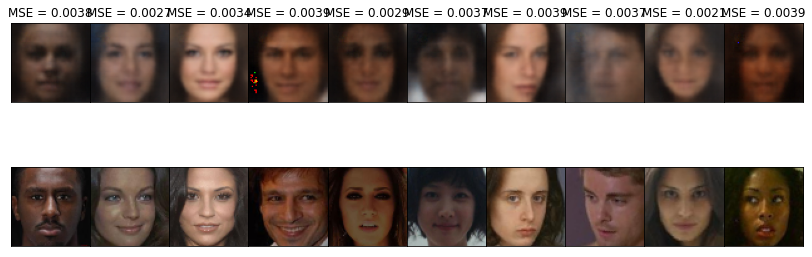

In [19]:
torch.manual_seed(87)
plt.figure(figsize=(12, 12))
trans_rgb = transforms.ToPILImage()

model.eval()
with torch.no_grad():
  num = 1
  for batch_id, data in enumerate(test_loader):
    data = data.to(device)
    output,a,b = model(data)
    MSE_loss = loss_function(output, data)
    image = trans_rgb(output[0].cpu())
    data = trans_rgb(data[0].cpu())

    if MSE_loss.item()<=0.004 and num<=10:
      plt.subplot(2,10,num)
      plt.title('MSE = '+ str(round(MSE_loss.item(),4)))
      fig = plt.gcf()
      fig.set_size_inches(11,4)
      plt.gca().xaxis.set_major_locator(plt.NullLocator())
      plt.gca().yaxis.set_major_locator(plt.NullLocator())
      plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0,wspace=0)
      plt.margins(0,0)
      plt.imshow(image)

      plt.subplot(2,10,num+10)
      fig = plt.gcf()
      fig.set_size_inches(11,4)
      plt.gca().xaxis.set_major_locator(plt.NullLocator())
      plt.gca().yaxis.set_major_locator(plt.NullLocator())
      plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0,wspace=0)
      plt.margins(0,0)
      plt.imshow(data)
      num+=1

  plt.show()
    

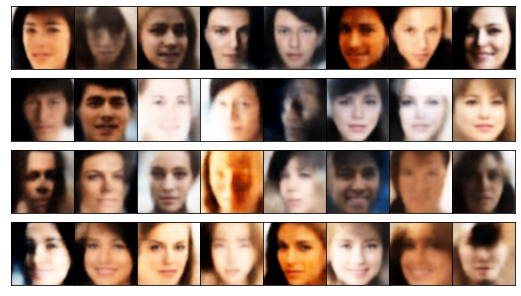

In [20]:

model.eval()
torch.manual_seed(69)
with torch.no_grad():
  for i in range(32):
    sample = model.reparameterize(torch.tensor([0]*1024).view(-1,1024),torch.tensor([1]*1024).view(-1,1024)).to(device)
    result = model.decode(sample)
    image = np.transpose(result[0].cpu().numpy(),(1,2,0))
    image = np.clip(image,0,1)
    plt.subplot(4,8,i+1)
    fig = plt.gcf()
    fig.set_size_inches(7,4)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0,wspace=0)
    plt.margins(0,0)
    plt.imshow(image)


In [16]:
# torch.save(model,'gdrive/My Drive/colab/hw3/problem1/1123')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
